In [119]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)
from functools import lru_cache
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

import warnings

## 1. Display Settings

In [120]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

In [121]:
geolocator = Nominatim(user_agent="MyApp")

## 2. Read the data

In [122]:
train = pd.read_csv(r"C:\Users\yashg\OneDrive\Desktop\flight-sagemaker\data\train.csv")
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,10975
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,5678


In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          6694 non-null   object
 1   date_of_journey  6694 non-null   object
 2   source           6694 non-null   object
 3   destination      6694 non-null   object
 4   dep_time         6694 non-null   object
 5   arrival_time     6694 non-null   object
 6   duration         6694 non-null   int64 
 7   total_stops      6694 non-null   int64 
 8   price            6694 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 470.8+ KB


In [124]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

# Changing Y_train

In [125]:
y_train

0       12898
1       13044
2       10975
3        2227
4        5678
        ...  
6689     8479
6690    15078
6691     8603
6692     8759
6693    11142
Name: price, Length: 6694, dtype: int64

## 4.2 Airline

In [126]:
X_train.airline

0             Jet Airways
1             Jet Airways
2               Air India
3                  IndiGo
4             Jet Airways
              ...        
6689             SpiceJet
6690    Multiple carriers
6691            Air India
6692             Air Asia
6693    Multiple carriers
Name: airline, Length: 6694, dtype: object

In [204]:
airline_transformer = Pipeline(steps = [
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
                                    ("encoder", MeanEncoder()),
                                	("scaler", PowerTransformer())
    
])

In [205]:
airline_transformer.fit_transform(X_train.loc[:, ["airline"]], y_train)

,airline
0,1.025481
1,1.025481
2,0.126046
3,-1.248070
4,1.025481
...,...
6689,-1.260045
6690,0.637312
6691,0.126046
6692,-1.260045


In [206]:
airline_transformer

Pipeline(steps=[('grouper',
                 RareLabelEncoder(n_categories=2, replace_with='Other',
                                  tol=0.1)),
                ('encoder', MeanEncoder()), ('scaler', PowerTransformer())])

## 4.3 date_of_journey

In [130]:
X_train.date_of_journey

0       2019-05-27
1       2019-06-12
2       2019-05-18
3       2019-06-03
4       2019-04-01
           ...    
6689    2019-06-09
6690    2019-05-09
6691    2019-05-18
6692    2019-05-18
6693    2019-04-09
Name: date_of_journey, Length: 6694, dtype: object

In [177]:
feature_to_extract = ["week", "day_of_week" ]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_week,date_of_journey_day_of_week
0,0.764706,0.000000
1,0.882353,0.333333
2,0.647059,0.833333
3,0.823529,0.000000
4,0.294118,0.000000
...,...,...
6689,0.823529,1.000000
6690,0.588235,0.500000
6691,0.647059,0.833333
6692,0.647059,0.833333


In [178]:
doj_transformer

Pipeline(steps=[('dt',
                 DatetimeFeatures(features_to_extract=['week', 'day_of_week'],
                                  format='mixed', yearfirst=True)),
                ('scaler', MinMaxScaler())])

### 4.3 source & destination

In [133]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Mumbai,Hyderabad
4,Mumbai,Hyderabad
...,...,...
6689,Kolkata,Banglore
6690,Delhi,Cochin
6691,Delhi,Cochin
6692,Delhi,Cochin


In [226]:
import json 
with open(r"C:\Users\yashg\OneDrive\Desktop\flight-sagemaker\dictionary_distance", 'r') as json_file:
    distance_dictionary = json.load(json_file)

In [235]:
def source_destination(train):
    sd_subset = train[["source","destination"]]
    sd_subset[["source", "destination"]] = sd_subset[["source", "destination"]].apply(lambda col: col.str.lower())
    sd_subset["source_destination"] = (sd_subset["source"].astype(str) + "_" + sd_subset["destination"])
    
    return pd.DataFrame(sd_subset["source_destination"], columns=["source_destination"])


def return_distance_df(train):
    distance = train["source_destination"].map(distance_dictionary)
    
    # Create a DataFrame with the calculated distance
    return pd.DataFrame({"distance_between_cities": distance})

    
## Lets fist convert airline coulumn to Countvectorizer() finction of feature_engine
sd_count_transformer = Pipeline(steps = [
                                    ( "source_destination" , FunctionTransformer(source_destination)),
                                    ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("count_encoder", CountFrequencyEncoder()),
                                	("scaler", PowerTransformer())
    
])

location_pipe2 = Pipeline(steps=[
    ( "source_destination" , FunctionTransformer(source_destination)),
    # ("grouper", RareLabelEncoder(tol=  0.1, replace_with = "Other", n_categories=2)),
	("encoder", FunctionTransformer(func=return_distance_df)),
    ("StandardScaler", StandardScaler())
])


location_transformer = FeatureUnion(transformer_list=[
	("part1", sd_count_transformer),
    ("part2", location_pipe2),
])

In [236]:
location_pipe2.fit_transform(location_subset)

,distance_between_cities
0,0.877331
1,-0.465397
2,0.877331
3,-2.959122
4,-2.959122
...,...
6689,-0.465397
6690,0.877331
6691,0.877331
6692,0.877331


In [182]:
location_pipe2 = Pipeline(steps=[
	("encoder", FunctionTransformer(func=return_distance_df)),
    ("StandardScaler", StandardScaler())
])

location_pipe2.fit_transform(location_subset)

,distance_between_cities
0,0.885519
1,-0.479402
2,0.885519
3,-2.937032
4,-2.937032
...,...
6689,-0.479402
6690,0.885519
6691,0.885519
6692,0.885519


In [183]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", sd_count_transformer),
    ("part2", location_pipe2),
])

location_transformer.fit_transform(location_subset, y_train)

,source_destination,distance_between_cities
0,1.071620,0.885519
1,-0.253821,-0.479402
2,1.071620,0.885519
3,-1.771796,-2.937032
4,-1.771796,-2.937032
...,...,...
6689,-0.253821,-0.479402
6690,1.071620,0.885519
6691,1.071620,0.885519
6692,1.071620,0.885519


In [139]:
location_transformer

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('source_destination',
                                                 FunctionTransformer(func=<function source_destination at 0x0000029E59152A20>)),
                                                ('grouper',
                                                 RareLabelEncoder(n_categories=2,
                                                                  replace_with='Other',
                                                                  tol=0.1)),
                                                ('count_encoder',
                                                 CountFrequencyEncoder()),
                                                ('scaler',
                                                 PowerTransformer())])),
                               ('part2',
                                Pipeline(steps=[('encoder',
                                                 FunctionTransformer(func=<function return_distance_df at 0x0000029E587FAD40>)),
                                                ('StandardScaler',
                                                 StandardScaler())]))])

### 4.4 dep_time & arrival_time

In [140]:
X_train.dep_time

0       20:55:00
1       18:55:00
2       09:45:00
3       21:20:00
4       02:55:00
          ...   
6689    11:35:00
6690    10:00:00
6691    12:00:00
6692    07:55:00
6693    08:00:00
Name: dep_time, Length: 6694, dtype: object

In [141]:
X_train.arrival_time

0       12:35:00
1       16:20:00
2       09:25:00
3       22:50:00
4       04:20:00
          ...   
6689    18:50:00
6690    01:30:00
6691    07:40:00
6692    13:25:00
6693    19:00:00
Name: arrival_time, Length: 6694, dtype: object

In [142]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,20:55:00,12:35:00
1,18:55:00,16:20:00
2,09:45:00,09:25:00
3,21:20:00,22:50:00
4,02:55:00,04:20:00
...,...,...
6689,11:35:00,18:50:00
6690,10:00:00,01:30:00
6691,12:00:00,07:40:00
6692,07:55:00,13:25:00


In [219]:
def dep_arrival(train):
    time_subset = train[["dep_time_part_of_day","arrival_time_part_of_day"]]
    time_subset[["dep_time_part_of_day", "arrival_time_part_of_day"]] = time_subset[["dep_time_part_of_day", "arrival_time_part_of_day"]].apply(lambda col: col.str.lower())
    time_subset["dept_arrival"] = (time_subset["dep_time_part_of_day"].astype(str) + "_" + time_subset["arrival_time_part_of_day"])
    
    return pd.DataFrame(time_subset["dept_arrival"], columns=["dept_arrival"])


In [187]:
time_transformer = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("label_encoder", FunctionTransformer(func=dep_arrival)),
    ("count_encoder", CountFrequencyEncoder()),
    ("scaler", PowerTransformer())
    # ("scaling", MinMaxScaler())
])

time_transformer.fit_transform(time_subset)

,dept_arrival
0,-1.987895
1,-0.818215
2,1.541732
3,-0.095486
4,-0.526121
...,...
6689,0.743214
6690,-0.049347
6691,-1.764013
6692,0.359861


In [188]:
time_transformer

Pipeline(steps=[('part',
                 FunctionTransformer(func=<function part_of_day at 0x0000029E591A4540>)),
                ('label_encoder',
                 FunctionTransformer(func=<function dep_arrival at 0x0000029E54947880>)),
                ('count_encoder', CountFrequencyEncoder()),
                ('scaler', PowerTransformer())])

In [189]:
## Standarize columns=  "total_stops", "duration"

stand = Pipeline(steps=[
    
	("scaling", StandardScaler())
])

stand.fit_transform(train.loc[:, ["duration", "total_stops"]])

,duration,total_stops
0,0.599507,0.284658
1,1.283545,0.284658
2,1.551211,1.804199
3,-1.085803,-1.234882
4,-1.095717,-1.234882
...,...,...
6689,-0.401765,0.284658
6690,0.579680,0.284658
6691,1.075359,1.804199
6692,-0.609951,0.284658


In [190]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'price'],
      dtype='object')

In [191]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,10975
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,5678
...,...,...,...,...,...,...,...,...,...
6689,SpiceJet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1,8479
6690,Multiple carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1,8759


In [207]:
column_transformer = ColumnTransformer(transformers=[
	("air", airline_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("stand", stand, ["duration", "total_stops"])],remainder="passthrough" ) 

column_transformer.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_week,doj__date_of_journey_day_of_week,location__source_destination,location__distance_between_cities,time__dept_arrival,stand__duration,stand__total_stops
0,1.025481,0.764706,0.000000,1.071620,0.885519,-1.987895,0.599507,0.284658
1,1.025481,0.882353,0.333333,-0.253821,-0.479402,-0.818215,1.283545,0.284658
2,0.126046,0.647059,0.833333,1.071620,0.885519,1.541732,1.551211,1.804199
3,-1.248070,0.823529,0.000000,-1.771796,-2.937032,-0.095486,-1.085803,-1.234882
4,1.025481,0.294118,0.000000,-1.771796,-2.937032,-0.526121,-1.095717,-1.234882
...,...,...,...,...,...,...,...,...
6689,-1.260045,0.823529,1.000000,-0.253821,-0.479402,0.743214,-0.401765,0.284658
6690,0.637312,0.588235,0.500000,1.071620,0.885519,-0.049347,0.579680,0.284658
6691,0.126046,0.647059,0.833333,1.071620,0.885519,-1.764013,1.075359,1.804199
6692,-1.260045,0.647059,0.833333,1.071620,0.885519,0.359861,-0.609951,0.284658


In [208]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('air',
                                 Pipeline(steps=[('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('encoder', MeanEncoder()),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['airline']),
                                ('doj',
                                 Pipeline(steps=[('dt',
                                                  DatetimeFeatures(features_to_extract=['week',
                                                                                        'day_of_week'],
                                                                   format='mixed',
                                                                   yearfirst=True)),
                                                 ('sca...
                                 Pipeline(steps=[('part',
                                                  FunctionTransformer(func=<function part_of_day at 0x0000029E591A4540>)),
                                                 ('label_encoder',
                                                  FunctionTransformer(func=<function dep_arrival at 0x0000029E54947880>)),
                                                 ('count_encoder',
                                                  CountFrequencyEncoder()),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['dep_time', 'arrival_time']),
                                ('stand',
                                 Pipeline(steps=[('scaling',
                                                  StandardScaler())]),
                                 ['duration', 'total_stops'])])

### 5. Feature Selection

In [209]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### 6. Putting it all Together

In [210]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_week,location__source_destination,location__distance_between_cities,time__dept_arrival,stand__duration,stand__total_stops
0,1.025481,0.764706,1.071620,0.885519,-1.987895,0.599507,0.284658
1,1.025481,0.882353,-0.253821,-0.479402,-0.818215,1.283545,0.284658
2,0.126046,0.647059,1.071620,0.885519,1.541732,1.551211,1.804199
3,-1.248070,0.823529,-1.771796,-2.937032,-0.095486,-1.085803,-1.234882
4,1.025481,0.294118,-1.771796,-2.937032,-0.526121,-1.095717,-1.234882
...,...,...,...,...,...,...,...
6689,-1.260045,0.823529,-0.253821,-0.479402,0.743214,-0.401765,0.284658
6690,0.637312,0.588235,1.071620,0.885519,-0.049347,0.579680,0.284658
6691,0.126046,0.647059,1.071620,0.885519,-1.764013,1.075359,1.804199
6692,-1.260045,0.647059,1.071620,0.885519,0.359861,-0.609951,0.284658


### Visualization

In [211]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline': 0.33102213119237417,
 'doj__date_of_journey_week': 0.17136121485343714,
 'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'location__source_destination': 0.12587020827275583,
 'location__distance_between_cities': 0.1257139940308999,
 'time__dept_arrival': 0.12021317549035866,
 'stand__duration': 0.41631526510966027,
 'stand__total_stops': 0.3890563531349809}

In [212]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'time__dept_arrival': 0.12021317549035866,
 'location__distance_between_cities': 0.1257139940308999,
 'location__source_destination': 0.12587020827275583,
 'doj__date_of_journey_week': 0.17136121485343714,
 'air__airline': 0.33102213119237417,
 'stand__total_stops': 0.3890563531349809,
 'stand__duration': 0.41631526510966027}

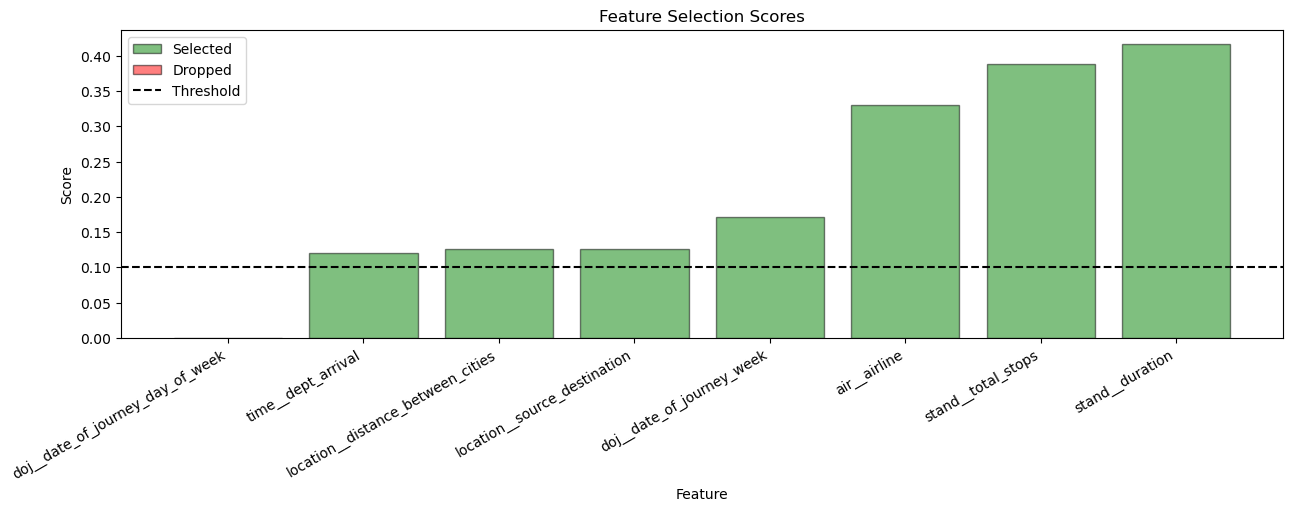

In [213]:
THRESHOLD = 0.05

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

In [214]:
column_transformer.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_week,doj__date_of_journey_day_of_week,location__source_destination,location__distance_between_cities,time__dept_arrival,stand__duration,stand__total_stops
0,1.025481,0.764706,0.000000,1.071620,0.885519,-1.987895,0.599507,0.284658
1,1.025481,0.882353,0.333333,-0.253821,-0.479402,-0.818215,1.283545,0.284658
2,0.126046,0.647059,0.833333,1.071620,0.885519,1.541732,1.551211,1.804199
3,-1.248070,0.823529,0.000000,-1.771796,-2.937032,-0.095486,-1.085803,-1.234882
4,1.025481,0.294118,0.000000,-1.771796,-2.937032,-0.526121,-1.095717,-1.234882
...,...,...,...,...,...,...,...,...
6689,-1.260045,0.823529,1.000000,-0.253821,-0.479402,0.743214,-0.401765,0.284658
6690,0.637312,0.588235,0.500000,1.071620,0.885519,-0.049347,0.579680,0.284658
6691,0.126046,0.647059,0.833333,1.071620,0.885519,-1.764013,1.075359,1.804199
6692,-1.260045,0.647059,0.833333,1.071620,0.885519,0.359861,-0.609951,0.284658


## VIF

In [215]:
ct = column_transformer.fit_transform(X_train, y_train)

In [216]:
vif_data = pd.DataFrame()
vif_data["feature"] = ct.columns
vif_data["VIF"] = [variance_inflation_factor(ct, i) for i in range(ct.shape[1])]

In [217]:
vif_data

,feature,VIF
0,air__airline,1.326698
1,doj__date_of_journey_week,1.924327
2,doj__date_of_journey_day_of_week,1.895699
3,location__source_destination,4.328195
4,location__distance_between_cities,3.503431
5,time__dept_arrival,1.054606
6,stand__duration,2.239801
7,stand__total_stops,2.776481
